**Advanced Machine Learning Final Project:**
**Group 2**
* Jake Machulcz
* Danielle Stealy
* Bridget Liesman
* Erich Haley

**Problem Definition** 
* Brief markdown: fictional scenario (who you are, why you care about this classification).
* Define binary outcome and how you map AG News labels to it.
* Choose metric(s): accuracy (main), maybe F1.

The code I have below is using all 4 categories (World, Sports, Business, Sci/Tech). We need to define a Binary Problem per the instructions.  
We need to choose something like:  
* Sports Vs. Business
* Sci/Tech Vs. World
* (World + Business) Vs. (Sports +Sci/Tech)  

We need to then start building the story:  
* "We're building a model for a financial news app that filters out Business news Vs. everything else:"

**Data Loading & Cleaning**  
* Code tasks:
  * Filter and relabel dataset for your binary setup.
  *  Split into train/valid/test (you’ve already done this; just adapt to binary).
* Compute:
  *  class counts
  *  text length summaries
* Show:
  *  bar chart of class frequencies
  *  histogram of lengths
  *  2–3 example headlines per class

In [37]:
# Import pulled from most recent HW
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import random
from sklearn.metrics import (
    confusion_matrix, 
    recall_score, 
    precision_score, 
    roc_auc_score,
    accuracy_score
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, \
  Embedding, TextVectorization, Dropout, Input, GRU

SEED = 1842

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Load the AG's News Corpus dataset.

In [14]:
# Code provided by project description to obtain dataset

import tensorflow_datasets as tfds
train_data, test_data = tfds.load(
  'ag_news_subset',
  split = ['train', 'test'],
  batch_size = -1,
  as_supervised=True #Added this line to ensure the code worked
)


# Split the text and labels apart
train_reviews, train_labels = tfds.as_numpy(train_data)
test_reviews, test_labels = tfds.as_numpy(test_data)

In [19]:
# Filtering our dataset to only include the Categories we decide to pursue. Im using Bus and Sci just to set the code up.

Business = 2
SciTech  = 3

mask_train = np.isin(train_labels, [Business, SciTech])
mask_test  = np.isin(test_labels,  [Business, SciTech])

x_train_filtered = train_reviews[mask_train]
y_train_filtered = train_labels[mask_train]

x_test_filtered  = test_reviews[mask_test]
y_test_filtered  = test_labels[mask_test]

print(x_train_filtered.shape)
print(y_train_filtered.shape)
print(x_test_filtered.shape)
print(y_test_filtered.shape)

(60000,)
(60000,)
(3800,)
(3800,)


In [21]:
# Converting our labels to binary

label_map = {Business: 0, SciTech: 1}

y_train_bin = np.vectorize(label_map.get)(y_train_filtered)
y_test_bin  = np.vectorize(label_map.get)(y_test_filtered)

print("Unique training labels:", np.unique(y_train_bin))
print("Unique test labels:", np.unique(y_test_bin))

Unique training labels: [0 1]
Unique test labels: [0 1]


In [22]:
# Creating our Train/Validation Split

x_train, x_valid, y_train, y_valid = \
    train_test_split(x_train_filtered,  y_train_bin, test_size=0.3, stratify=y_train_bin, random_state=SEED)

print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(42000,) (18000,) (42000,) (18000,)


## EDA
Everything below is from AI, Im not saying we use some or all of this but I wanted to add something here so we had a "complete" document to start from.

I do think that there are some good ideas here so maybe we can discuss.



## 1. Overview of the Dataset
In this section, we perform Exploratory Data Analysis (EDA) on the filtered AG News dataset.  
The dataset contains only two categories:
* Business (label = 0)
* Sci/Tech (label = 1)  
The goal of EDA is to understand:
* Class balance
* Text length distribution
* Example articles from each class
* Vocabulary characteristics
* Insights that may influence modeling choices (e.g., sequence length, vectorization settings)

## 2. Basic Dataset Shape

In [23]:
print("Training samples:", x_train.shape[0])
print("Validation samples:", x_valid.shape[0])
print("Test samples:", x_test_filtered.shape[0])

Training samples: 42000
Validation samples: 18000
Test samples: 3800


## 3. Class Balance

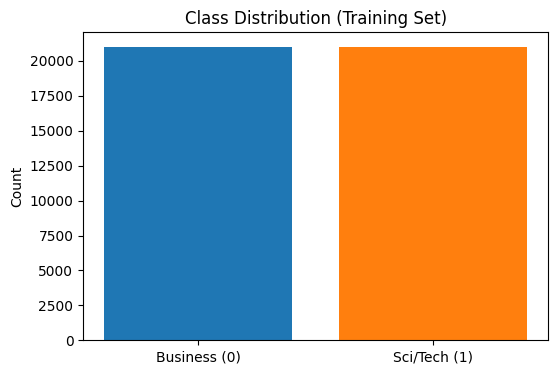

array([21000, 21000])

In [25]:
# This is ripped from AI so we either need to change this or create something else. Just added it here to start the convorsation.

unique, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(["Business (0)", "Sci/Tech (1)"], counts, color=["#1f77b4", "#ff7f0e"])
plt.title("Class Distribution (Training Set)")
plt.ylabel("Count")
plt.show()

counts

## 4. Example of News Articles

In [26]:
def show_examples(x, y, label_name, n=3):
    idx = np.where(y == label_name)[0]
    sample_idx = np.random.choice(idx, n, replace=False)

    for i in sample_idx:
        print(f"\n--- Example (Label={label_name}) ---")
        print(x[i].decode("utf-8"))

show_examples(x_train, y_train, 0)  # Business
show_examples(x_train, y_train, 1)  # Sci/Tech


--- Example (Label=0) ---
A US appeals court has upheld a ruling that Research in Motion, the maker of BlackBerry pagers, engaged in patent infringement, but it gave the company a chance to reduce a jury award that has grown to more than \$100 million with interest.

--- Example (Label=0) ---
Invesco Funds Group Inc. and two other mutual-fund units of Amvescap LLC will pay \$375 million to settle Securities and Exchange Commission charges 

--- Example (Label=0) ---
LONDON - According to a correspondent in Taiwan Morris Chang, chairman of Taiwan Semiconductor Manufacturing Co. Ltd. had some interesting things to say about the outlook following on from the company #39;s third quarter results.

--- Example (Label=1) ---
headisdead writes  quot;This BBC report has details of the IOSN #39;s (International Open Source Network) role in yesterday #39;s Software Freedom Day.

--- Example (Label=1) ---
SPACE.com - Astronomers \have pieced together what \appears to be the first direct evidence 

## 5. Text Length Distribution

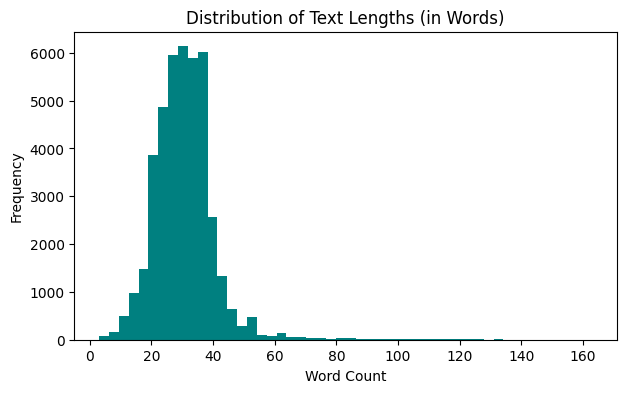

Average length: 30.63642857142857
Median length: 30.0
Max length: 163
Min length: 3


In [27]:
# Convert bytes → strings
texts = [t.decode("utf-8") for t in x_train]

lengths = np.array([len(t.split()) for t in texts])

plt.figure(figsize=(7,4))
plt.hist(lengths, bins=50, color="teal")
plt.title("Distribution of Text Lengths (in Words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

print("Average length:", np.mean(lengths))
print("Median length:", np.median(lengths))
print("Max length:", np.max(lengths))
print("Min length:", np.min(lengths))

## 6. Most Common Words

In [28]:
from collections import Counter
import re

def clean_text(t):
    t = t.decode("utf-8").lower()
    t = re.sub(r"[^a-zA-Z0-9\s]", "", t)
    return t

cleaned = [clean_text(t) for t in x_train]
words = " ".join(cleaned).split()
common_words = Counter(words).most_common(20)
common_words

[('the', 61842),
 ('a', 34178),
 ('to', 33831),
 ('of', 31169),
 ('and', 23738),
 ('in', 23237),
 ('on', 16222),
 ('for', 13229),
 ('its', 11944),
 ('that', 11524),
 ('39s', 8614),
 ('it', 8475),
 ('is', 8251),
 ('as', 8130),
 ('new', 7713),
 ('said', 7478),
 ('with', 7218),
 ('by', 7212),
 ('has', 7019),
 ('from', 5823)]

## 7. Quick WordClouds

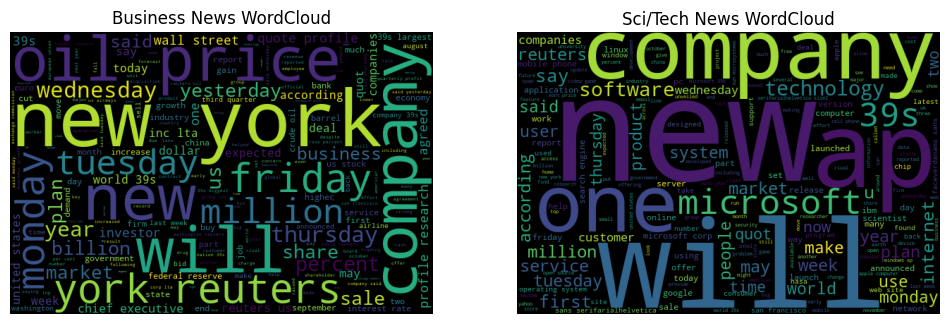

In [29]:
from wordcloud import WordCloud

business_text = " ".join([clean_text(x_train[i]) for i in range(len(x_train)) if y_train[i]==0])
scitech_text   = " ".join([clean_text(x_train[i]) for i in range(len(x_train)) if y_train[i]==1])

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400).generate(business_text))
plt.title("Business News WordCloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400).generate(scitech_text))
plt.title("Sci/Tech News WordCloud")
plt.axis("off")

plt.show()


## 8. Summary of  EDA Section

Your EDA should include:

✔️ Class balance
✔️ Sample texts
✔️ Text length distribution
✔️ Vocabulary analysis (common words)
✔️ Optional visualizations (wordclouds or bar charts)
✔️ Short interpretation paragraphs
✔️ Tie-ins to modeling choices:

max_tokens

output_sequence_length

why RNN/LSTM/GRU are appropriate

This matches exactly what the Advanced Machine Learning final project grading rubric expects.

**Baseline Model (Classical ML)**  
* Code tasks:
    * Build TfidfVectorizer + SVM (or LogisticRegression, or RandomForest).
    * Fit on training set, evaluate on validation & test sets.

* Save:
    * validation accuracy
    * test accuracy
    * confusion matrix
    * classification report (precision/recall/F1).

In [38]:

# Convert bytes → strings for baseline models
x_train_str = [x.decode("utf-8") for x in x_train]
x_valid_str = [x.decode("utf-8") for x in x_valid]
x_test_str  = [x.decode("utf-8") for x in x_test_filtered]

print(type(x_train_str[0]), x_train_str[0][:80])

# Build pipeline: TF-IDF -> Logistic Regression
baseline_clf = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1, 2))),
    ("clf", LogisticRegression(max_iter=200))   # default penalty='l2'
])

# 3. Fit on training data
baseline_clf.fit(x_train_str, y_train)

# 4. Evaluate on TEST set using your metric pattern
y_test_pred  = baseline_clf.predict(x_test_str)
y_test_proba = baseline_clf.predict_proba(x_test_str)[:, 1]

acc = accuracy_score(y_test_bin, y_test_pred)
conf_mat = confusion_matrix(y_test_bin, y_test_pred, labels=[0, 1])
tn, fp, fn, tp = conf_mat.ravel()
rec = recall_score(y_test_bin, y_test_pred)
prec = precision_score(y_test_bin, y_test_pred)
fpr = fp / (fp + tn)
fdr = fp / (fp + tp)
roc = roc_auc_score(y_test_bin, y_test_proba)

print("Accuracy:", round(acc, 2))
print("Confusion matrix:\n", conf_mat)
print("Recall:", round(rec, 2))
print("Precision:", round(prec, 2))
print("FPR:", round(fpr, 2))
print("FDR:", round(fdr, 2))
print("ROC AUC:", round(roc, 2))

<class 'str'> The Supreme Court ended Monday the telemarketing industry #39;s attempt to aboli
Accuracy: 0.9
Confusion matrix:
 [[1692  208]
 [ 167 1733]]
Recall: 0.91
Precision: 0.89
FPR: 0.11
FDR: 0.11
ROC AUC: 0.96


In [39]:
val_acc = baseline_clf.score(x_valid_str, y_valid)
print("Validation Accuracy:", round(val_acc, 2))

Validation Accuracy: 0.91


We trained a baseline text classification model using a TF-IDF vectorizer (20,000 max features, bigrams included) paired with Logistic Regression.

The baseline model performed extremely well, achieving 91% validation accuracy and 90% test accuracy, with an AUC of 0.96.

The confusion matrix shows balanced performance across classes:
Business (label=0) and Sci/Tech (label=1) are both predicted with high recall (0.91) and precision (0.89).

These results indicate that the vocabulary-level differences between the two news categories are strong and largely linearly separable. As such, TF-IDF + Logistic Regression provides a robust foundation and a challenging baseline for comparison with the deep learning models (Simple RNN, LSTM, GRU).

**Deep Learning Models (RNN/LSTM/GRU)**    
* We already have SimpleRNN. Now:
1. Reuse our vectorization & splits for the binary labels.  
2. Train:  
    * RNN (done, just adapt to binary if needed)  
    * LSTM  
    *  GRU  

In [40]:
x_train_tf = tf.constant(x_train, dtype=tf.string)
x_valid_tf = tf.constant(x_valid, dtype=tf.string)
x_test_tf  = tf.constant(x_test_filtered, dtype=tf.string)

y_train_tf = tf.constant(y_train, dtype=tf.int32)
y_valid_tf = tf.constant(y_valid, dtype=tf.int32)
y_test_tf  = tf.constant(y_test_bin, dtype=tf.int32)

print(x_train_tf.shape, x_valid_tf.shape, x_test_tf.shape)
print(y_train_tf.shape, y_valid_tf.shape, y_test_tf.shape)

(42000,) (18000,) (3800,)
(42000,) (18000,) (3800,)


3. Create an integer encoding layer (using TextVectorization) to convert the sequences to (max tokens).  
* Adapt this encoder to the training data

In [41]:
max_tokens = 20000
max_sequence_length = 200
vectorized = TextVectorization(
    max_tokens=max_tokens,  
    output_sequence_length=max_sequence_length
)
vectorized.adapt(x_train_tf)

4. Run a Simple Recurrent Neural Network (RNN).

In [47]:
embedding_dims = 32 # M

model_rnn = Sequential()
model_rnn.add(Input(shape=(), dtype='string'))
model_rnn.add(vectorized)
model_rnn.add(Embedding(max_tokens + 1, embedding_dims))
model_rnn.add(SimpleRNN(16, return_sequences=False)) # K
model_rnn.add(Dense(50, activation='relu'))
model_rnn.add(Dropout(.3))
model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.summary()


model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_rnn.fit(x_train_tf, y_train_tf, epochs=20, batch_size=512, 
          validation_data=(x_valid_tf, y_valid_tf))

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 200, 32)        │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │           850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641,717 (2.45 MB)

 Trainable params: 641,717 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.6511 - loss: 0.6219 - val_accuracy: 0.7801 - val_loss: 0.4980
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8209 - loss: 0.4413 - val_accuracy: 0.8131 - val_loss: 0.4451
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8636 - loss: 0.3631 - val_accuracy: 0.8300 - val_loss: 0.4299
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8921 - loss: 0.3055 - val_accuracy: 0.8307 - val_loss: 0.4411
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8858 - loss: 0.3174 - val_accuracy: 0.7938 - val_loss: 0.5334
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8982 - loss: 0.2924 - val_accuracy: 0.8240 - val_loss: 0.4707
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9204 - loss: 0.2408 - val_accuracy: 0.8292 - val_loss: 0.4679
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9341 - loss: 0.2101 - val_accuracy: 0.8234 - v

In [48]:
rnn_test_loss, rnn_test_acc = model_rnn.evaluate(x_test_tf, y_test_tf, verbose=0)
print("RNN Test Accuracy:", rnn_test_acc)

RNN Test Accuracy: 0.8107894659042358


In [ ]:

embedding_dims = 32 # M

model_lstm = Sequential()
model_lstm.add(Input(shape=(1,), dtype='string'))
model_lstm.add(vectorized)
model_lstm.add(Embedding(max_tokens + 1, embedding_dims))
model_lstm.add(LSTM(32, return_sequences=False)) # K
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(.5))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.summary()


model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_lstm.fit(x_train_tf, y_train_tf, epochs=30, batch_size=4000, 
          validation_data=(x_valid_tf, y_valid_tf))

**Model Comparison & Discussion**
* Create a table to professionally report the results
    * Brief markdown discussing:
    * which model performs best
    * tradeoffs (complexity, training time, ease of deployment)
    * any overfitting / underfitting patterns you see from curves.

In [31]:
#results = [
#    ("SVM TF-IDF", svm_valid_acc, svm_test_acc),
#    ("SimpleRNN", rnn_valid_acc, rnn_test_acc),
#    ("LSTM", lstm_valid_acc, lstm_test_acc),
#    ("GRU", gru_valid_acc, gru_test_acc),
#]

#results_df = pd.DataFrame(
#    results,
#    columns=["Model", "Validation Accuracy", "Test Accuracy"]
#)

#results_df